# Weather-Forecasting

## Intro:
Weather-forcasting model is a model to be developed concerned with predicting weather states for the future, based on past few years' data to support Tourism in Riyadh, Saudi Arabia.
For developing a weather-forcasting model, we will start by implementing data cleaning and EDA tasks, these tasks will help us to prepare our data for analysis, visualization, and gaining insights about data to make the model more efficient and accurate.

## Import libraries:
we will import all the libraries that we need to complete our EDA and data cleaning tasks

In [30]:
#Start by importing API library

import openmeteo_requests

In [31]:
#Import any other needed libraries

import requests_cache
import pandas as pd
from retry_requests import retry
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from datetime import timedelta


import plotly.express as px

%matplotlib inline

## Setting up API data 
This section goes through important steps of setting up Open-Meteo API, Creating instance of the API , defining API URL and required parameters , processing first response data and extracting the daily weather variables from the API response and assigning them to separate variables for further processing, then organizing them in a dictionary.

In [32]:
# Setup the Open-Meteo API client with cache and retry on error
#Create API client instance

cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)


In [33]:
#Define URL and parameters

url = "https://archive-api.open-meteo.com/v1/archive?latitude=24.6877&longitude=46.7219&start_date=2021-01-01&end_date=2024-01-01&daily=weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,daylight_duration,rain_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant&timezone=auto"
params = {
	"latitude": 24.6877,
	"longitude": 46.7219,
	"start_date": "2021-01-01",
	"end_date": "2024-01-01",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_mean", "daylight_duration", "rain_sum", "precipitation_hours", "wind_speed_10m_max", "wind_direction_10m_dominant"],
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

In [34]:
# Process first location.
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


Coordinates 24.71001625061035°N 46.68810272216797°E
Elevation 611.0 m asl
Timezone b'Asia/Riyadh' b'+03'
Timezone difference to GMT+0 10800 s


In [35]:
# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(4).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(5).ValuesAsNumpy()
daily_rain_sum = daily.Variables(6).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(7).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(8).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(9).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
daily_data["daylight_duration"] = daily_daylight_duration
daily_data["rain_sum"] = daily_rain_sum
daily_data["precipitation_hours"] = daily_precipitation_hours
daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant

daily_dataframe = pd.DataFrame(data = daily_data)
print(daily_dataframe)


                          date  weather_code  temperature_2m_max  \
0    2020-12-31 21:00:00+00:00          51.0           19.869501   
1    2021-01-01 21:00:00+00:00           0.0           20.819500   
2    2021-01-02 21:00:00+00:00           1.0           21.319500   
3    2021-01-03 21:00:00+00:00          51.0           19.869501   
4    2021-01-04 21:00:00+00:00           1.0           20.619501   
...                        ...           ...                 ...   
1091 2023-12-27 21:00:00+00:00           1.0           25.269501   
1092 2023-12-28 21:00:00+00:00          55.0           22.169500   
1093 2023-12-29 21:00:00+00:00          53.0           21.119501   
1094 2023-12-30 21:00:00+00:00           3.0           21.719501   
1095 2023-12-31 21:00:00+00:00           1.0           23.619501   

      temperature_2m_min  temperature_2m_mean  apparent_temperature_mean  \
0              11.469500            15.452835                  13.454375   
1              11.519500       

# Overview of the Dataset


In this section, we are aiming to have a good understanding of our data by doing some visualizing of the patterns, characteristics, and relationships between variables, and we want to introduce some basic information about our dataset, such as its size, head, and null values..

In [36]:
#number of rows and columns  (dataset size)
daily_dataframe.shape

(1096, 11)

**based on above output**, we have 1096 rows, where each row represent a day, so we have 1096 days.. and we have 11 columns where each column represents an attribute/feature/variable

In [37]:
#Important info about the data
print(daily_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         1096 non-null   datetime64[ns, UTC]
 1   weather_code                 1096 non-null   float32            
 2   temperature_2m_max           1096 non-null   float32            
 3   temperature_2m_min           1096 non-null   float32            
 4   temperature_2m_mean          1096 non-null   float32            
 5   apparent_temperature_mean    1096 non-null   float32            
 6   daylight_duration            1096 non-null   float32            
 7   rain_sum                     1096 non-null   float32            
 8   precipitation_hours          1096 non-null   float32            
 9   wind_speed_10m_max           1096 non-null   float32            
 10  wind_direction_10m_dominant  1096 non-null   flo

**Our data** consists of 11 columns as we said which are providing information about different aspects. <br>
10 of the columns are numeric varying between int and float types, and the last one of the 11 columns is of "Date" type which represents the recorded date.<br>
While the "Weather Code" column contains numerical codes representing weather conditions, these initially have nominal values but are represented in numbers, futrther preprocessing is going to be implemented on this column.<br>
Next, The Maximum Temperature, Minimum Temperature and Mean Temperature columns indicating Information about air temperatures recorded in Celsius degrees. However, the Mean Apparent Temperature column takes into account factors like humidity, wind chill, and solar radiation to provide the average perceived temperature.<br>
Another column is the Daylight Duration column, which records the duration of daylight in seconds.<br>
Furthermore, Rain Sum column which indicates the total amount of rainfall measured during the day in millimeters, and Precipitation Hours recording the number of hours of precipitation. <br>
Additional columns including Maximum Wind Speed column representing the highest observed wind speed in kilometers per hour, while the Dominant Wind Direction column indicates the primary direction of the wind flow on a given day, measured in degrees. <br>
These weather data columns contain helpful information for understanding and assessing weather trends, such as temperatures, rainfall, wind speed, and direction.

As a conculsion, this code generated info about the following: <br>
1-The total number of rows in the DataFrame. we can conclude that we have 1096 rows "days".<br>
2-The column names and their corresponding data types. we can conclude that we have 11 attributes, these are:<br>
2.1:date of type date<br>
2.2:weather code of type float<br>
2.3:max temperature of type float<br>
2.4:min temperature of type float<br>
2.5:mean temperature of type float<br>
2.6:mean appearnt temp of type float<br>
2.7:daylight duration of type float<br>
2.8:rain sum of type float<br>
2.9:precipitation hours of type float<br>
2.10:max wind speed of type float<br>
2.11:dominant wind direction of type float<br>

3-The number of non-null values in each column. we can notice that all values of all columns for all rows are non-null (no null values in the dataset)<br>
4-The memory usage of the DataFrame. which is 68.6 KB


In [38]:
#sample of our data
daily_dataframe.head()

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_mean,daylight_duration,rain_sum,precipitation_hours,wind_speed_10m_max,wind_direction_10m_dominant
0,2020-12-31 21:00:00+00:00,51.0,19.869501,11.4695,15.452835,13.454375,38292.546875,1.0,6.0,18.678415,135.350052
1,2021-01-01 21:00:00+00:00,0.0,20.819500,11.5195,15.836166,14.800246,38315.589844,0.0,0.0,11.770403,116.496925
2,2021-01-02 21:00:00+00:00,1.0,21.319500,10.0195,15.950751,14.666530,38340.441406,0.0,0.0,14.882420,136.674774
3,2021-01-03 21:00:00+00:00,51.0,19.869501,11.3195,15.665334,12.634810,38367.082031,0.6,3.0,21.388969,129.250763
4,2021-01-04 21:00:00+00:00,1.0,20.619501,11.3195,15.817418,13.062580,38395.480469,0.0,0.0,19.881649,128.988510


**As shown** in the output, we have a sample of the first 5 rows of the dataset (The last day of 2020 and the first 4 days of 2021), with their unprocessed column values, we can notice that these five days' values such as temperature and other values are somewhat close to each other with slight variation due to their consequence data recording days


In [39]:
#check missing value in the dataset
daily_dataframe.isnull().sum()

date                           0
weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_mean      0
daylight_duration              0
rain_sum                       0
precipitation_hours            0
wind_speed_10m_max             0
wind_direction_10m_dominant    0
dtype: int64

**As shown** in the above code output, we can conclude that we have no null or missing data for any of the columns. As a result, there is no need to fill or drop any of the columns or the rows.

In [40]:
#to check duplicate rows and reomve any redundent or useless record
sum(daily_dataframe.duplicated())

0

**As seen** from the output, there is no duplicate rows, this indicates that the data is accurate and no logging and data collecting errors been made. Thus, there is no need to perform duplicate-rows handling such as reomving redundent or useless records as each record represent unique day.

## Data Preprocessing
After we have seen the data, and viewed a sample of it, it's clear that the data needs some preprocessing and cleaning to make it easier to use, interpret, process and analyze. <br> <br>
We will start by normalizing the "time/duration" columns.
Since we have two columns that refer to duration, which are "daylight_duration" and "precipitation_hours" but these are not measured in a standarized unit. Thus we will work on the "daylight_duration" column to rescale it from seconds to hours to match with the latter. i.e: "precipitation_hours"

In [41]:
#Convert all the column's values to hours
daily_dataframe["daylight_duration"] = daily_dataframe["daylight_duration"] / 3600

In [42]:
print(daily_dataframe["daylight_duration"])

0       10.636819
1       10.643219
2       10.650123
3       10.657523
4       10.665411
          ...    
1091    10.612862
1092    10.616827
1093    10.621362
1094    10.626452
1095    10.632094
Name: daylight_duration, Length: 1096, dtype: float32


Now we can see that all values have been converted to hours, now it's easier to interpert and it's standarized with the other column, this way it's easier to interpert and visualize the data.

## Concept Hierarchy Generation
## Type conversion

In this section, we are going to preprocess the column "weather_code", this column has a couple of issues with its current representation and collected form. <br>
The first is that the column is treated as a numeric column, which is misleading. Although this column has its values as digits/numbers, these are nominal not numeric values because it makes no sense performing Mathematical operations on them. <br>
The second is that this column takes 100 values based on WMO universally accepted weather code. This number is considered a large number having in mind that these values are close and similar to each other, Based on the WMO website, we can group and generalize these 100 values to 8 groups as follows: <br><br>
Values (0-19): No precipitation, fog, ice fog (except for 11 and 12), duststorm, sandstorm, drifting or blowing snow at the station* at the time of observation or, except for 09 and 17, during the preceding hour <br>
Values (20-29): Precipitation, fog, ice fog or thunderstorm at the station during the preceding hour but not at the time of observation
 <br>
Values (30-39): Duststorm, sandstorm, drifting or blowing snow <br>
Values (40-49): Fog or ice fog at the time of observation<br>
Values (50-59): precipitation at the station at the time of observation and drizzle <br>
Values (60-69): Rain and drizzle<br>
Values (70-79):Solid precipitation not in showers and drizzle<br>
Values (80-99): Showery precipitation, or precipitation with current or recent thunderstorm and drizzle <br><br>
So these are the 8 categories that we will perform the Concept Hierarchy Generation based on.

In [43]:
#convert the 100 values to 8 values (from 0 to 7) based on the WMO categories. "Concept Hierarchy Generation"

daily_dataframe["weather_code"] = pd.cut(daily_dataframe["weather_code"], bins=[-1, 19, 29, 39, 49, 59, 69, 79, 99], labels=[0, 1, 2, 3, 4, 5, 6, 7], include_lowest=True)
print(daily_dataframe['weather_code'])

0       4
1       0
2       0
3       4
4       0
       ..
1091    0
1092    4
1093    4
1094    0
1095    0
Name: weather_code, Length: 1096, dtype: category
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]


As shown in the above output, we have converted the 100 values to 8 groups of related weather codes.
We will visualize these new values later in the EDA section.

After the conversion, we will print the unique values of the column to check the new values.

In [44]:
weather = daily_dataframe['weather_code']
unique = weather.unique()
print(unique)

[4, 0, 5]
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]


We can notice that only 3 of the 8 codes occured in Riyadh in our dataset, that indicates that Riyadh doesn't encounter various weather conditions especially the extreme ones. We will analyze what these values mean some more in the EDA section.

## Discretization
In this section , we will preprocess "wind_direction_10m_dominant" and "rain_sum" columns.

**wind_direction_10m_dominant column** represents the direction of the wind 10m above the ground, However, this column's values are measured in degrees, which could be infeasible and difficult to interpert and work with. As a result, we will perform Discretization to convert these degrees (0-360) degrees to categories (North, Northeast , East, Southeast, South, Southwest, West and Northwest). <br>
The conversion is based on the common knowledge and conventional division of the degrees into eight equal segments, this logic is widely used in meteorology, environmental science and navigation.

In [45]:
# We will define a function to perform the conversion
def conversion(degrees):
    if degrees < 22.5 or degrees >= 337.5:
        return 'North'
    elif 22.5 <= degrees < 67.5:
        return 'Northeast'
    elif 67.5 <= degrees < 112.5:
        return 'East'
    elif 112.5 <= degrees < 157.5:
        return 'Southeast'
    elif 157.5 <= degrees < 202.5:
        return 'South'
    elif 202.5 <= degrees < 247.5:
        return 'Southwest'
    elif 247.5 <= degrees < 292.5:
        return 'West'
    else:
        return 'Northwest'


    
daily_dataframe['wind_direction_10m_dominant'] = daily_dataframe['wind_direction_10m_dominant'].apply(conversion)

print(daily_dataframe['wind_direction_10m_dominant'])



0       Southeast
1       Southeast
2       Southeast
3       Southeast
4       Southeast
          ...    
1091    Southeast
1092    Southeast
1093    Southeast
1094    Southeast
1095    Southeast
Name: wind_direction_10m_dominant, Length: 1096, dtype: object


After the conversion, we will print the unique values of the column to check the new values.

In [46]:
wind_dir = daily_dataframe['wind_direction_10m_dominant']
unique = wind_dir.unique()
print(unique)

['Southeast' 'East' 'North' 'Northwest' 'South' 'West' 'Southwest'
 'Northeast']


 Now we have the new values all set and ready, noticing that all 8 values occured in the dataset "North, Northeast , East, Southeast, South, Southwest, West and Northwest".. <br>
Later in the EDA section, we will visualize this column and its values, and analyze it.

**As for rain_sum column**, it represents the total amount of rain measured during the day in millimeters! Furthermore, As it measured in millilitres and many times will not exceeds 1 millilmeter; this will affect understanding the values. Therefore, we will perform Discretization as we did in the wind direction column, we will convert it based on Weather and Climate Services Division, NCHM standards.

In [47]:
rain_sum = pd.Series(['Light' if i < 10 
                     else 'Moderate' if 10 <= i < 30 
                     else 'Heavy' for i in daily_dataframe['rain_sum']])
print(rain_sum)

0       Light
1       Light
2       Light
3       Light
4       Light
        ...  
1091    Light
1092    Light
1093    Light
1094    Light
1095    Light
Length: 1096, dtype: object


## EDA Exploratory Data Analysis

In this section, we are going to tread through the critical process of performing initial investigations on data in order to discover patterns and verify assumptions using summary statistics and graphical representations, along with critical transformations on some of the columns to make it easier to manipulate, study, understand, analyze and use the data.

## Univariant EDA

In this section, we will analyze and visualize the dataset by taking one variable at a time, using different plots and visualization techniques.

In [48]:
#five statistical summray of the 7 Numerical columns
print(daily_dataframe.describe())

       temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
count         1096.000000         1096.000000          1096.000000   
mean            33.503391           20.539118            27.280083   
std              8.675450            7.586475             8.371368   
min             10.919499            0.619500             6.446583   
25%             26.369501           14.069500            20.083562   
50%             35.044500           21.119501            28.454918   
75%             41.469501           27.719501            35.305438   
max             45.969501           35.469501            40.513252   

       apparent_temperature_mean  daylight_duration     rain_sum  \
count                1096.000000        1096.000000  1096.000000   
mean                   23.947433          12.152861     0.223723   
std                     8.336675           1.059932     1.550985   
min                     1.020123          10.601584     0.000000   
25%                    16.653

Analyzing the results, we can observe the following:


1. Temperature: The mean maximum temperature (32.415 degrees Celsius) indicates that, on average, the temperature isn't high, providing perfect experience for tourists in Riyadh. The mean minimum temperature (19.393 degrees Celsius) indicated that the temperature drops a bit during cooler seasons, However, it is still considered warm enough for outdoor activities.

2. Apparent Temperature: The mean apparent temperature (22.389 degrees Celsius), which might differ from the actual temperature due to factors like wind and humidity. 22 degrees suggest a cool weather for tourists to experience different activities.

3. Daylight Duration: The average daylight duration (43,752.6 minutes) shows a long duration of daylight experienced.

4. Rain Sum and Precipitation Hours: The low mean rain sum (0.322) and precipitation hours (0.418) indicate that, on average, the Capital Riyadh experience low rainfall or precipitation events. This could be due to the location of the city, since it's drier than many other cities in Saudi Arabia.

5. Wind Speed and Direction: The mean maximum wind speed (22.511 meters per second) indicates a moderate average wind speed. While The mean dominant wind direction (141.039 degrees) meaning that most of the wind comes from the southeast.

### Rain Sum

We will count the rain_sum for each level, as it affects the temperature when it is raining; so we can consider it while building a model to predict the temperature!

In [49]:
#count rain_sum for each Level of rainfall in a day based on Weather and Climate Services Division, NCHM
countRain = rain_sum.value_counts()

pd.concat([countRain], axis=1, keys=['counts'])

,counts
Light,1090
Moderate,6


As shown in the table, the rain sum in Saudi Arabia specifically in Riyadh classified as Light rain as it is the most assurance.

### Apparent temperature

The apparent temperature will affect the temperature, so it is important to check the values and where is the most values Occurs to check if we need more cleaning.

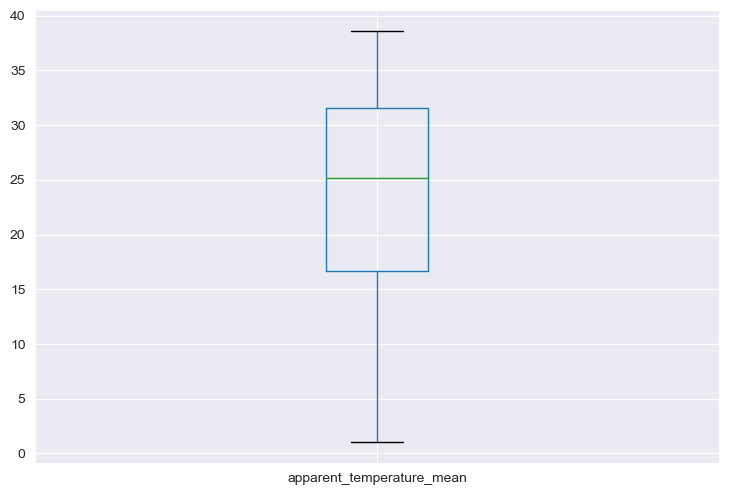

In [50]:
#check for outliers
fig = plt.figure(figsize=(30,20))
fig.add_subplot(3,3,1)
boxplot=daily_dataframe.boxplot(column=['apparent_temperature_mean'],notch=False)

The graph shows that the values between approximately 1-39 degrees and the average of temperature values around 25 degrees. 

In [51]:
# Mean Temperature in Riyadh in summer vacation -in July and August
daily_dataframe['Year'] = daily_dataframe['date'].dt.year

# Filter the data for July and August
filtered_df = daily_dataframe[(daily_dataframe['date'].dt.month.isin([7, 8]))]

# Calculate the mean temperature for each year
mean_temp_df = filtered_df.groupby('Year')['temperature_2m_mean'].mean().reset_index()

figure = px.bar(mean_temp_df, x="Year", y="temperature_2m_mean",
                title='Mean Temperature in Riyadh - July and August by Year',
                labels={'temperature_2m_mean': 'Mean Temperature'})
figure.show()

As we have temperature_2m_mean Column, it will help us to Calculate the mean for July and Augest which are the summer vacation months. The graph shows that it doesn’t vary much from a year to another; as for 2021 the average is 37.3 while in 2022 is 36.7 and 2023 is near from 2021 that is 37.5, knowing that all values in celsius degree.

### Relationship Between Columns

We already build a hypothesis that there is a relationship between Temperature and wind speed. In order to evalute the hypothesis; we will use some graphs to check it.

<Axes: >

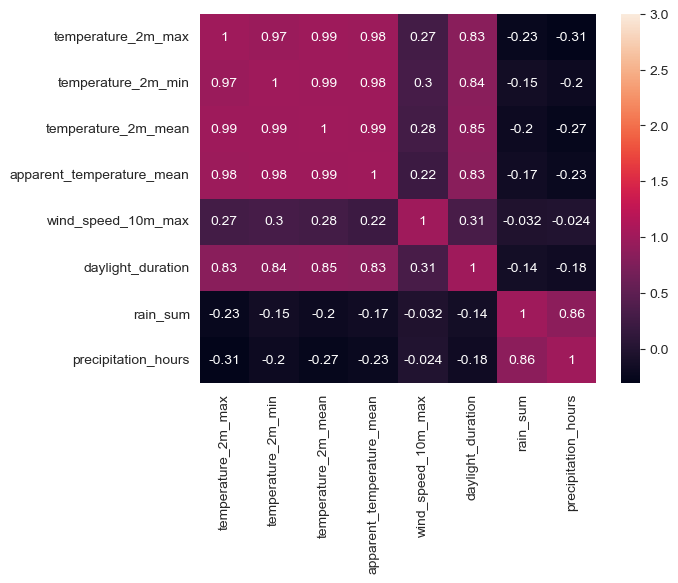

In [52]:
# Relationship Between all columns
corrs = daily_dataframe[['temperature_2m_max','temperature_2m_min','temperature_2m_mean','apparent_temperature_mean',
                         'wind_speed_10m_max', 'daylight_duration','rain_sum','precipitation_hours']].corr()
sns.heatmap(corrs,annot=True,vmax=3)

Unfortunately, the graph shows that the wind_speed_10m_max and temperature_2m_mean have a weak relationship that the correlation between them is -0.28 which is closer to zero.<br>
To see how the relationship is between them we will use Scatter plot to have more understanding.

In [53]:
figure=px.scatter(data_frame =daily_dataframe,x="wind_speed_10m_max",
                 y="temperature_2m_mean",size="temperature_2m_mean",
                 trendline="ols",title="Relationship between temperature and wind speed")
figure.show()

The graph shows us that the wind speed doesn't change much over the time. While on the other hand, the temperature change a lot because of changing seasons. It is possible to have a large wind speed in all seasons, unlike the temperature it depends on the season.

### Daylight duration

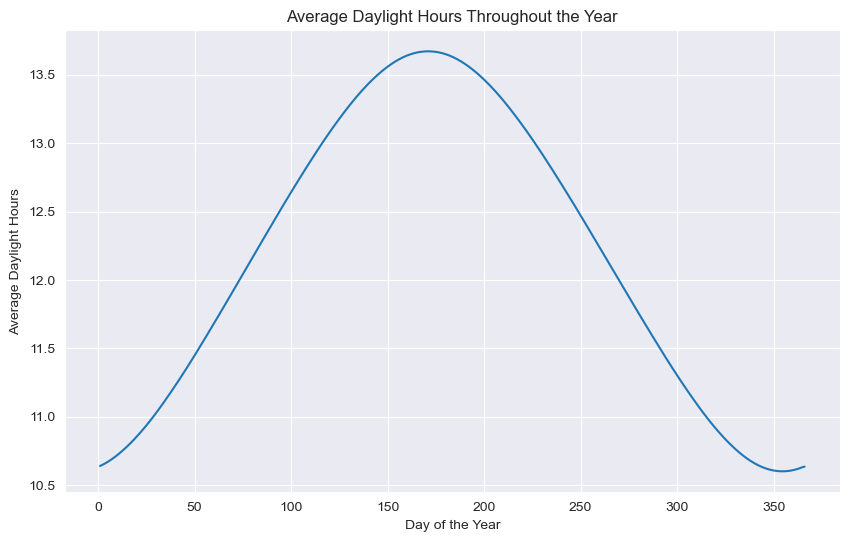

In [54]:
# Calculate the average daylight duration for each day of the year
average_daylight = daily_dataframe.groupby(daily_dataframe['date'].dt.dayofyear)['daylight_duration'].mean()

# Plot the average daylight duration for each day of the year
plt.figure(figsize=(10, 6))
plt.plot(average_daylight)
plt.title('Average Daylight Hours Throughout the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Average Daylight Hours')
plt.grid(True)
plt.show()

As shown in the figure, the average daylight duration for each day of the year varies a lot from day to day. The figure shows also that in some days it is equal to zero which could be on winter season as it the sun does not intense most of the time.

### Weather code
We will model the weather_code column and further analyze it after we have converted its values and preprocessed it in the preprocessing section. We will use Histogram to do so.
After we have reduced the dimention of the weather_code column, we noticed that we only have 3 out of 8 values occuring in the dataset. Consequently, we are interested in the frequency to interpert this result.

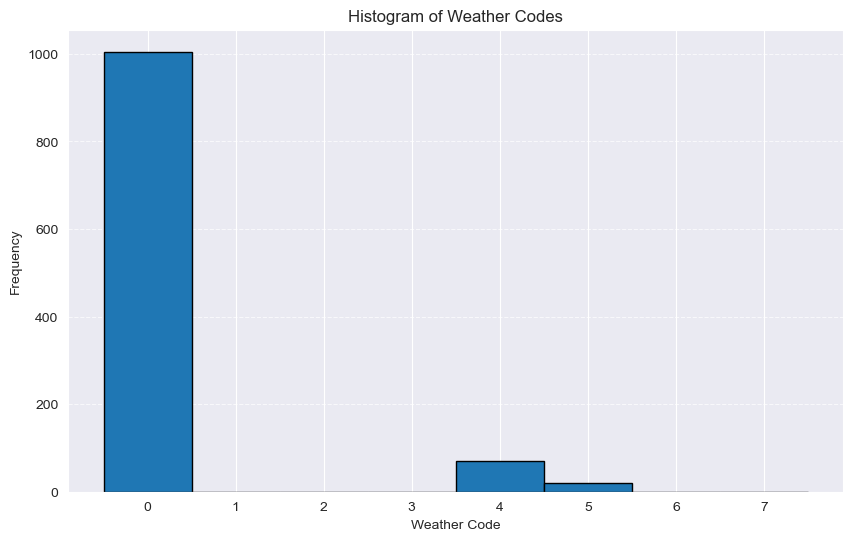

In [55]:

plt.figure(figsize=(10, 6))
plt.hist(daily_dataframe['weather_code'], bins=range(0, 9), edgecolor='black', align='left')
plt.title('Histogram of Weather Codes')
plt.xlabel('Weather Code')
plt.ylabel('Frequency')
plt.xticks(range(0, 8))  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


As shown in the graph, only 3 unique Weather codes occured in Riyadh during the three years of the recorded dataset.<br>
These codes are: <br>
 code 0 = No precipitation, no fog, no ice fog, no duststorm, no sandstorm, no drifting or blowing snow. i.e: clear weather<br>
 code 4 = precipitation and drizzle <br>
 code 5 = Rain and drizzle <br>
This mostly refers to three weather conditions : clear, drizzle and rain.<br>
The most frequent weather code is code 0 , indicating clear skies and good visibility.<br>
The next most frequent code is 4 then 5 indicating rain, and Precipitation.<br>
The other codes have frequency of 0 , these codes are: <br>

code 1 : Precipitation, fog, ice fog or thunderstorm.<br>
code 2 : Duststorm, sandstorm, drifting or blowing snow.<br>
code 3 : Fog or ice fog.<br>
code 6 : Solid precipitation not in showers and drizzle.<br>
code 7 : Showery precipitation, or precipitation with current or recent thunderstorm and drizzle.<br>
These conditions are not common in Riyadh, and only occurs few time every few years, Thus it could be due to the rarity of these conditions, and the location of the observation and recording station. <br>


The recorded conditions are usually to the like of tourists and indicate weather that is suitable for outdoor activities and events, Which is an important factor for optimizing tourism in Riyadh.

### Wind direction
As we have preprocessed the wind direction column, we are interested in visualizing it and getting to understand it some more. We will use the pie chart to visualize this column.

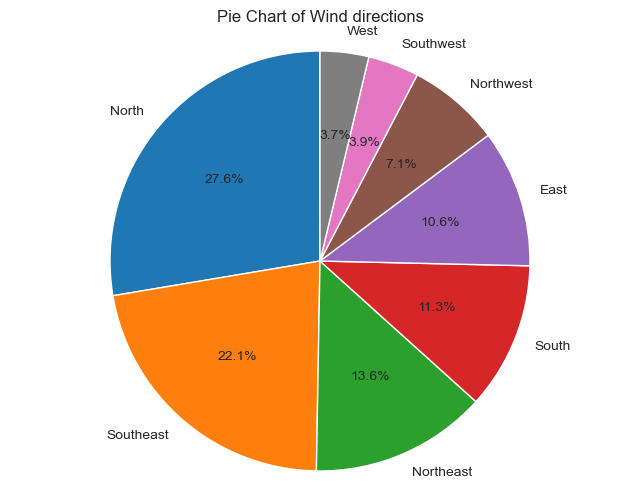

In [56]:
vals = daily_dataframe['wind_direction_10m_dominant']

# count of each category
value_counts = vals.value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Wind directions')
plt.axis('equal') 
plt.show()

As shown by the pie chart, the most frequent wind direction is the northren wind.<br>

--The North wind in Riyadh usually originates from the northern regions of Saudi Arabia, like Arar and Rafha. It's generally cooler and drier than wind from other directions. Thus, It may contribute to lower temperatures.

--The South wind in Riyadh generally originates from the southern regions of Saudi Arabia, like Jeddah.. Usually from the Red Sea, it brings warm and humid air to the Riyadh. It contributes to higher temperatures and high humidity, since it comes from coastal regions.

--The West wind in Riyadh originates from the Red Sea and the western deserts. It brings dry and warm air masses.
It can contribute to higher temperatures and low humidity levels.


--The East wind in Riyadh often originates from the the Arabian Gulf countries.
It carries moist air and can contribute to increased humidity levels, it can contribute to rainfall.

It's noticed that the most frequent wind directions are North and Southeast, these indicate cooler and warmer air respectivley.
Then comes the Northeast, South and east wind refering to cooler, warmer and moist wind respectivley. With the rest of the directions with a very low frequency.